# Introduction
This notebook contains a working example to show usage of the image perturbation and classifier-based saliency map generation API.

This example will follow an application-like use-case where we define a functionally rigid process that transforms an input image into a number of saliency heat-maps based on our black-box classifier's output, visualizing them over the input image.
We will show that it is easy to change which of our API implementations are used in the application without impacting the application's successful execution, first using a sliding-window perterbation algorithm and then using the RISE perturbation algorithm.

This will necessarilly include the use of a classification model to perform the role of the black-box classifier that we will be determining the saliency for.
We will fill this role here with a PyTorch Imagenet-pretrained ResNet18 network.

### Table of Contents
* [The test image](#The-test-image)
* [The "application"](#The-"application")
* [Black-box Classifier](#Black-box-Classifier)
* [XAI Components](#XAI-Components)
* [Calling the Application](#Calling-the-Application)

### Additional Python Requirements
The following additional python packages are required for this notebook besides the usual depedencies for `xaitk-saliency`:
- jupyter
- torch
- torchvision

### Miscellaneous
*Note*: When using the `from_config_dict` method below,
it is not unusual for the below code to throwback a warning
indicating missing psycopg2 and caffe modules.
Please disregard any such warnings.

Reference for implementation: Zeiler MD, Fergus R. Visualizing 
and understanding convolutional networks. InEuropean conference
on computer vision 2014 Sep 6 (pp. 818-833). Springer, Cham.

License for test image used may be found in 'COCO-LICENSE.txt'.

# The test image
We will test this application on the following image.
We know that this image contains the ImageNet classes of "boxer" and "tiger cat".

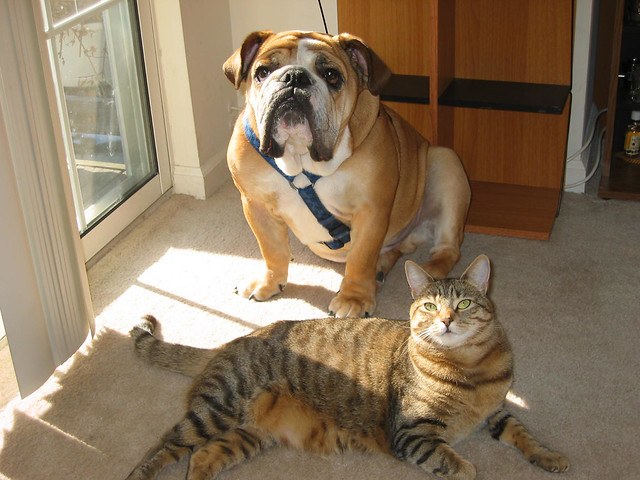

In [1]:
import PIL.Image
import urllib.request

urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', "catdog.jpg")
test_image_filename = 'catdog.jpg'
PIL.Image.open(test_image_filename)

# The "application"
First we will set up our application as a function with defined inputs for
  * the image
  * black-box classifier
  * image perturbation API implementation
  * saliency map generation API implementation

For the purposes of this tool, let's say that the input blackbox classifier must take in one image and output a 1D vector of per-class confidences (`Callable[[PIL.Image.Image], np.ndarray]`) for simplicity.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from typing import Callable
from xaitk_saliency import PerturbImage, ImageClassifierSaliencyMapGenerator

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


def app(
    image_filepath: str,
    # Assuming outputs `nClass` length arrays.
    blackbox_classify: Callable[[PIL.Image.Image], np.ndarray],
    perturber: PerturbImage,
    sal_map_generator: ImageClassifierSaliencyMapGenerator,
):
    # Load the image
    ref_image = PIL.Image.open(image_filepath)
    # Use the perterbation API implementation input to generate a bunch of images.
    # We will use the outputs here multiple times later so we will just aggregate
    # the output here.
    pert_imgs, pert_masks = zip(*perturber(ref_image))
    pert_masks = np.asarray(pert_masks)
    print(f"Perterbed images: {len(pert_imgs)}")
    print(f"Perterbation masks: {pert_masks.shape}")

    # Visualize some example perturbed images before heading into blackbox classification
    n = 4
    print(f"Visualizing {n} random perturbed images...")
    rng = np.random.default_rng(seed=0)
    rng_idx_lst = sorted(rng.integers(0, len(pert_imgs)-1, n))
    plt.figure(figsize=(n*4, 4))
    for i, rnd_i in enumerate(rng_idx_lst):
        plt.subplot(1, n, i+1)
        plt.title(f"pert_imgs[{rnd_i}]")
        plt.axis('off')
        plt.imshow(pert_imgs[rnd_i])

    # For the saliency heatmap generation API we need reference image predictions as well as
    # the predictions for each of the perturbed images.
    ref_preds = blackbox_classify(ref_image)
    print(f"Ref preds: {ref_preds.shape}")
    pert_preds = np.asarray([
        blackbox_classify(pi)
        for pi in pert_imgs
    ])

    print(f"Pert preds: {pert_preds.shape}")
    sal_maps = sal_map_generator(ref_preds, pert_preds, pert_masks)
    print(f"Saliency maps: {sal_maps.shape}")
    
    # Visualize the saliency heat-maps
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(16, 4))
    plt.subplot(1, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')

    for i, class_sal_map in enumerate(sal_maps):
        plt.subplot(1, sub_plot_ind, i+2)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            class_sal_map,
            cmap='jet', alpha=0.3
        )
        plt.title(f"Class #{i+1} Saliency Heatmap")
        plt.axis('off')

    plt.show()

# Black-box Classifier
In this example we will use a basic PyTorch-based pretrained ResNet18 model and use it's softmax output as classification confidences.
Since this model normally outputs 1000 classes, we will, for simplicity of example, constrain the output to the two classes that we happen to know are relevant for our test image.

In [3]:
# Set up our "black box" classifier using PyTorch and it's ImageNet pretrained ResNet18.
# We will constrain the output of our classifier here to the two classes that are relevant
# to our test image for the purposes of this example.
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms

CUDA_AVAILABLE = torch.cuda.is_available()


model = models.resnet18(pretrained=True)
model = model.eval()
if CUDA_AVAILABLE:
    model = model.cuda()

# These are some simple helper functions to perform prediction with this model
model_input_size = (224, 244)
model_loader = transforms.Compose([
    transforms.Resize(model_input_size), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


# Grabbing the class labels associated with this model.
if not os.path.isfile('imagenet_classes.txt'):
    !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

f = open("imagenet_classes.txt", "r")
categories = [s.strip() for s in f.readlines()]


# For this test, we will use an image with both a cat and a dog in it.
# Let's only consider the saliency of two class predictions.
sal_class_labels = ['boxer', 'tiger cat']
sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]


def blackbox_classifier(test_image: PIL.Image.Image) -> np.ndarray:
    image_tensor = model_loader(test_image).unsqueeze(0)
    if CUDA_AVAILABLE:
        image_tensor = image_tensor.cuda()
    feature_vec = model(image_tensor)
    # Converting feature extractor output to probabilities.
    class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()
    # Only return the confidences for the focus classes
    return class_conf[sal_class_idxs]

# XAI Components
Here we will setup our XAI components comprised of image perturbation and classifier-based saliency map generation.

We will start with the sliding-window perturbation method and the occlusion-based saliency map generation method.

We additionally construct a second perturber, RISE, that we will use in a second invocation of the "application" to show that it still functions successfully due to API consistency, but with different results as per using a different algorithm.

In [4]:
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindowPerturb
from xaitk_saliency.impls.perturb_image.rise import RISEPertubation
from xaitk_saliency.impls.vis_sal_classifier.occlusion_scoring import OcclusionScoring

perturber_slidingwindow = SlidingWindowPerturb((50, 50), (20, 20), threads=4)
perturber_rise = RISEPertubation(1000, 8, 0.5, seed=0, threads=4)
sal_map_generator = OcclusionScoring()

# Calling the Application
Here we will show that can invoke the same "application" (function) with different `xaitk-saliency` API interface implementations while still successfully executing, visualizing the different results that are generated.

Perterbed images: 884
Perterbation masks: (884, 480, 640)
Visualizing 4 random perturbed images...
Ref preds: (2,)


/home/local/KHQ/paul.tunison/.cache/pypoetry/virtualenvs/xaitk-saliency-b8zmqbMt-py3.8/lib64/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Pert preds: (884, 2)
Saliency maps: (2, 480, 640)


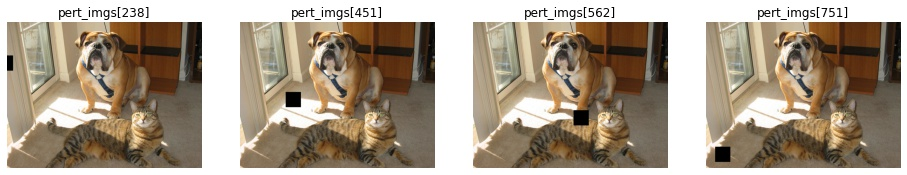

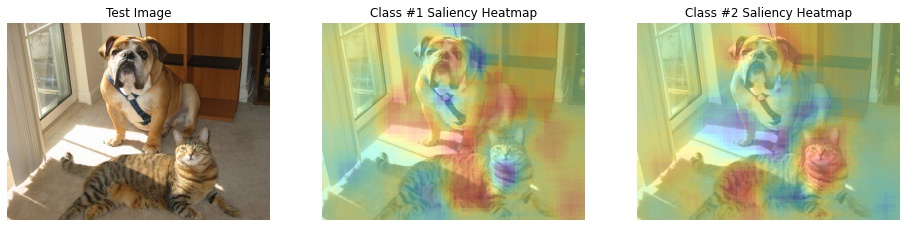

In [5]:
app(
    test_image_filename,
    blackbox_classifier,
    perturber_slidingwindow,
    sal_map_generator
)

Perterbed images: 1000
Perterbation masks: (1000, 480, 640)
Visualizing 4 random perturbed images...
Ref preds: (2,)
Pert preds: (1000, 2)
Saliency maps: (2, 480, 640)


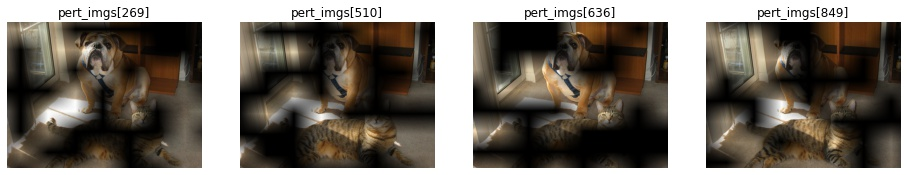

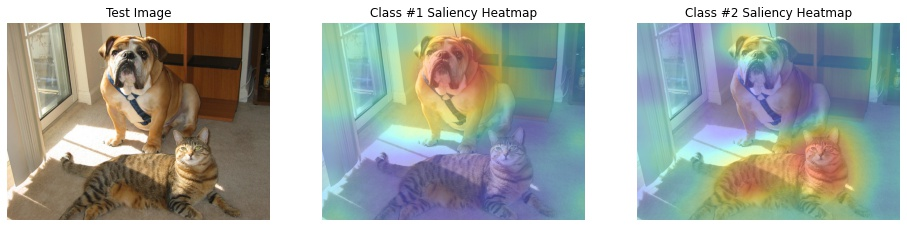

In [6]:
app(
    test_image_filename,
    blackbox_classifier,
    perturber_rise,  # The change
    sal_map_generator
)